In [1]:
import netCDF4
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.colors as mcolors
from matplotlib import cm

# For cartography
#import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
import earthpy as et

# These commands set-up proper figure printing inside a dark jupyter theme
plt.style.use('seaborn-white')
from jupyterthemes import jtplot
jtplot.style(theme='grade3',context='paper', ticks=True, grid=False)

In [2]:
# All data sets have the same spatial resolution...which makes the below it bit easier
fp = ('/home/smchartrand/Documents/Research/Climate Change Planning/CMIP5 Climate Change Data/DATA/pr_Amon_bcc-csm1-1-m_rcp60_r1i1p1_200601-210012.nc')
fp1 = ('/home/smchartrand/Documents/Research/Climate Change Planning/CMIP5 Climate Change Data/DATA/pr_Amon_CCSM4_rcp60_r1i1p1_200601-210012.nc')
fp2 = ('/home/smchartrand/Documents/Research/Climate Change Planning/CMIP5 Climate Change Data/DATA/pr_Amon_CESM1-CAM5_rcp60_r1i1p1_200601-210012.nc')

# BCC-CSM1 GCM - Beijing Climate Center Climate System Model (BCC_CSM1.1)
# Open the data using a context manager
with xr.open_dataset(fp) as file_nc:
    # Open the data
    moPrcp_xr = file_nc
    # moPrcp_xr = file_nc.rio.write_crs(file_nc.rio.crs, inplace=True)
    

# CCSM4 GCM - Community Climate System Model Version 4
# Open the data using a context manager
with xr.open_dataset(fp1) as file_nc:
    # Open the data
    moPrcp_xr1 = file_nc
    # moPrcp_xr = file_nc.rio.write_crs(file_nc.rio.crs, inplace=True)
    
# CESM1-CAM5 GCM - Community Earth System Model Version 1 - Community Atmospheric Model version 5
# Open the data using a context manager
with xr.open_dataset(fp2) as file_nc:
    # Open the data
    moPrcp_xr2 = file_nc
    # moPrcp_xr = file_nc.rio.write_crs(file_nc.rio.crs, inplace=True)

# Evaluate the data if one wishes to do so    
#moPrcp_xr2

In [3]:
# Grab the geographic data from the loaded file
lon = moPrcp_xr.variables['lon'][:]
lat = moPrcp_xr.variables['lat'][:]
time_var = moPrcp_xr.variables['time']

lon1 = moPrcp_xr1.variables['lon'][:]
lat1 = moPrcp_xr1.variables['lat'][:]
time_var1 = moPrcp_xr1.variables['time']

lon2 = moPrcp_xr2.variables['lon'][:]
lat2 = moPrcp_xr2.variables['lat'][:]
time_var2 = moPrcp_xr2.variables['time']

/home/smchartrand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  
/home/smchartrand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  
/home/smchartrand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead

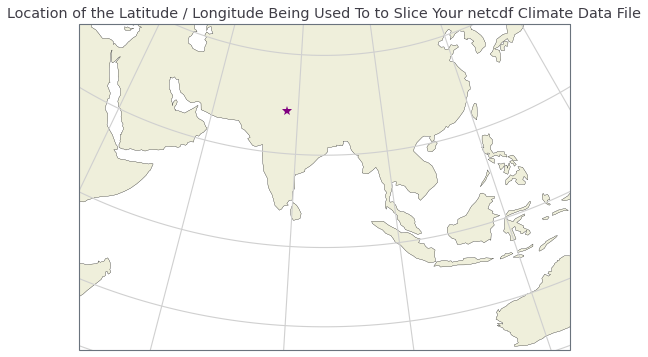

In [4]:
# specify some locations to extract time series
loni = 77.3; lati = 28.61 # New Delhi 

# find closest index to specified value
def near(array,value):
    idx=(abs(array-value)).argmin()
    return idx

# Find nearest point to desired location (could also interpolate, but more work)
ix = near(lon, loni)
iy = near(lat, lati)

ix1 = near(lon1, loni)
iy1 = near(lat1, lati)

ix2 = near(lon2, loni)
iy2 = near(lat2, lati)

# Create a spatial map of your selected location with cartopy
extent = [lon1[ix] - 40, lon1[ix] + 40, lat1[iy] + 30, lat1[iy] - 30]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

f, ax = plt.subplots(figsize=(12, 6),subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})
ax.coastlines()
# Plot the selected location 
ax.plot(loni-360, lati,'r*', 
        transform=ccrs.PlateCarree(),
       color="purple", markersize=10)

ax.set_extent(extent)
ax.set(title="Location of the Latitude / Longitude Being Used To to Slice Your netcdf Climate Data File")

# Adds continent boundaries to the map
ax.add_feature(cfeature.LAND, edgecolor='black')

ax.gridlines()
plt.show()

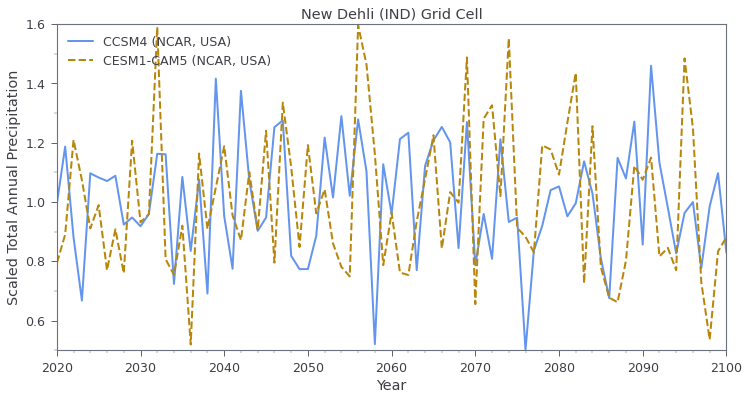

In [5]:
# Calculate the number of days in a month for the loaded data set
month_length = moPrcp_xr.time.dt.days_in_month
month_length1 = moPrcp_xr1.time.dt.days_in_month
month_length2 = moPrcp_xr2.time.dt.days_in_month

# Slice the data spatially using a single lat/lon point
pt = moPrcp_xr['pr'].sel(lat=lat[iy],lon=lon[ix])
pt1 = moPrcp_xr1['pr'].sel(lat=lat1[iy1],lon=lon1[ix1])
pt2 = moPrcp_xr2['pr'].sel(lat=lat2[iy2],lon=lon2[ix2])

# Depth of monthly total precipitation in metric units [mm]
moPrcpM_xr = pt * 86400 * month_length
moPrcpM_xr1 = pt1 * 86400 * month_length1
moPrcpM_xr2 = pt2 * 86400 * month_length2
#print(moPrcpM_xr)

# Sum precipitation by year
anPrcp_xr = moPrcpM_xr.groupby('time.year').sum('time')
anPrcp_xr1 = moPrcpM_xr1.groupby('time.year').sum('time')
anPrcp_xr2 = moPrcpM_xr2.groupby('time.year').sum('time')

# Average annual precipitation
anPrcp_xrAvg = anPrcp_xr.mean()
anPrcp_xr1Avg = anPrcp_xr1.mean()
anPrcp_xr2Avg = anPrcp_xr2.mean()

# Scaled prcipitation by respective means
anPrcp_xrScaled = anPrcp_xr / anPrcp_xrAvg
anPrcp_xr1Scaled = anPrcp_xr1 / anPrcp_xr1Avg
anPrcp_xr2Scaled = anPrcp_xr2 / anPrcp_xr2Avg

labels = ('CCSM4 (NCAR, USA)','CESM1-CAM5 (NCAR, USA)')
# You can clean up your plot as you wish using standard matplotlib approaches
f, ax = plt.subplots(figsize=(12, 6))
anPrcp_xr1Scaled.plot.line(hue='lat',
                    #marker="o",
                    ax=ax,
                    color="cornflowerblue",
                     linestyle='-',
                    linewidth = '2',
                    #markerfacecolor="purple",
                    #markeredgecolor="purple")
                    )
anPrcp_xr2Scaled.plot.line(hue='lat',
                    #marker="o",
                    ax=ax,
                    color="darkgoldenrod",
                    linestyle='--',
                    linewidth = '2',
                    #markerfacecolor="lightblue",
                    #markeredgecolor="lightblue",
                          )                          
ax.set_xlim(2020,2100)
ax.set_ylim(0.5,1.6)
ax.set(title="New Dehli (IND) Grid Cell")
ax.legend(labels)
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
plt.xlabel("Year")
plt.ylabel("Scaled Total Annual Precipitation")
# Uncomment the line below if you wish to export the figure as a .png file
# plt.savefig("single_point_timeseries.png")
plt.show()

/home/smchartrand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  
/home/smchartrand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  
/home/smchartrand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead

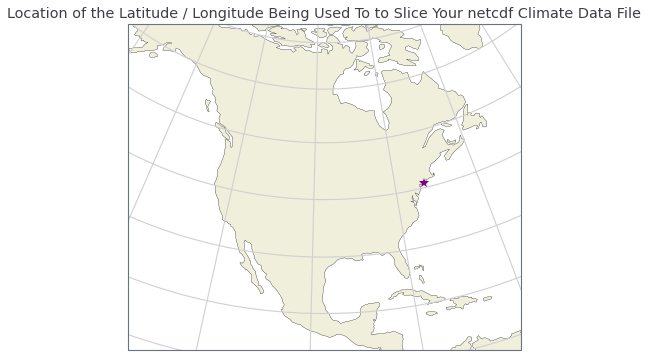

In [6]:
# specify some locations to extract time series
loni1 = 287; lati1 = 40.75 # New York City

# find closest index to specified value
def near(array,value):
    idx=(abs(array-value)).argmin()
    return idx

# Find nearest point to desired location (could also interpolate, but more work)
ix_1 = near(lon, loni1)
iy_1 = near(lat, lati1)

ix1_1 = near(lon1, loni1)
iy1_1 = near(lat1, lati1)

ix2_1 = near(lon2, loni1)
iy2_1 = near(lat2, lati1)

# Create a spatial map of your selected location with cartopy
extent = [lon1[ix1_1] - 60, lon1[ix1_1] + 10, lat1[iy1_1] + 30, lat1[iy1_1] - 30]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

f, ax = plt.subplots(figsize=(12, 6),subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})
ax.coastlines()
# Plot the selected location 
ax.plot(loni1, lati1,'r*', 
        transform=ccrs.PlateCarree(),
       color="purple", markersize=10)

ax.set_extent(extent)
ax.set(title="Location of the Latitude / Longitude Being Used To to Slice Your netcdf Climate Data File")

# Adds continent boundaries to the map
ax.add_feature(cfeature.LAND, edgecolor='black')

ax.gridlines()
plt.show()

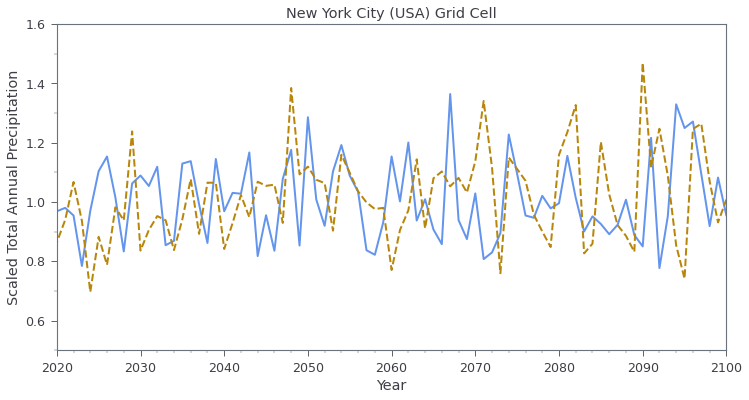

In [7]:
# Slice the data spatially using a single lat/lon point
pt_1 = moPrcp_xr['pr'].sel(lat=lat[iy_1],lon=lon[ix_1])
pt1_1 = moPrcp_xr1['pr'].sel(lat=lat1[iy1_1],lon=lon1[ix1_1])
pt2_1 = moPrcp_xr2['pr'].sel(lat=lat2[iy2_1],lon=lon2[ix2_1])
# Depth of monthly total precipitation in metric units [mm]
moPrcpM_xr_1 = pt_1 * 86400 * month_length
moPrcpM_xr1_1 = pt1_1 * 86400 * month_length1
moPrcpM_xr2_1 = pt2_1 * 86400 * month_length2
#print(moPrcpM_xr)

# sum precipitation by year
anPrcp_xr_1 = moPrcpM_xr_1.groupby('time.year').sum('time')
anPrcp_xr1_1 = moPrcpM_xr1_1.groupby('time.year').sum('time')
anPrcp_xr2_1 = moPrcpM_xr2_1.groupby('time.year').sum('time')

# Average annual precipitation
anPrcp_xr_1Avg = anPrcp_xr_1.mean()
anPrcp_xr1_1Avg = anPrcp_xr1_1.mean()
anPrcp_xr2_1Avg = anPrcp_xr2_1.mean()

# Scaled prcipitation by respective means
anPrcp_xr_1Scaled = anPrcp_xr_1 / anPrcp_xr_1Avg
anPrcp_xr1_1Scaled = anPrcp_xr1_1 / anPrcp_xr1_1Avg
anPrcp_xr2_1Scaled = anPrcp_xr2_1 / anPrcp_xr2_1Avg


# You can clean up your plot as you wish using standard matplotlib approaches
f, ax = plt.subplots(figsize=(12, 6))
anPrcp_xr1_1Scaled.plot.line(hue='lat',
                    #marker="o",
                    ax=ax,
                    color="cornflowerblue",
                     linestyle='-',
                    linewidth = '2',
                    #markerfacecolor="purple",
                    #markeredgecolor="purple")
                    )
anPrcp_xr2_1Scaled.plot.line(hue='lat',
                    #marker="o",
                    ax=ax,
                    color="darkgoldenrod",
                    linestyle='--',
                    linewidth = '2',
                    #markerfacecolor="lightblue",
                    #markeredgecolor="lightblue")
                    )
ax.set_xlim(2020,2100)
ax.set_ylim(0.5,1.6)
ax.set(title="New York City (USA) Grid Cell")
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
plt.xlabel("Year")
plt.ylabel("Scaled Total Annual Precipitation")

# Uncomment the line below if you wish to export the figure as a .png file
# plt.savefig("single_point_timeseries.png")
plt.show()

/home/smchartrand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  
/home/smchartrand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  
/home/smchartrand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead

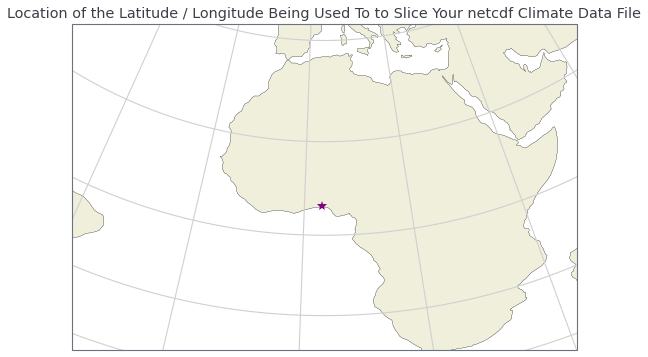

In [8]:
# specify some locations to extract time series
loni2 = 3.4; lati2 = 6.5 # Lagos

# find closest index to specified value
def near(array,value):
    idx=(abs(array-value)).argmin()
    return idx

# Find nearest point to desired location (could also interpolate, but more work)
ix_2 = near(lon, loni2)
iy_2 = near(lat, lati2)

ix1_2 = near(lon1, loni2)
iy1_2 = near(lat1, lati2)

ix2_2 = near(lon2, loni2)
iy2_2 = near(lat2, lati2)

# Create a spatial map of your selected location with cartopy
extent = [lon1[ix1_2] - 40, lon1[ix1_2] + 40, lat1[iy1_2] + 30, lat1[iy1_2] - 30]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

f, ax = plt.subplots(figsize=(12, 6),subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})
ax.coastlines()
# Plot the selected location 
ax.plot(loni2-360, lati2,'r*', 
        transform=ccrs.PlateCarree(),
       color="purple", markersize=10)

ax.set_extent(extent)
ax.set(title="Location of the Latitude / Longitude Being Used To to Slice Your netcdf Climate Data File")

# Adds continent boundaries to the map
ax.add_feature(cfeature.LAND, edgecolor='black')

ax.gridlines()
plt.show()

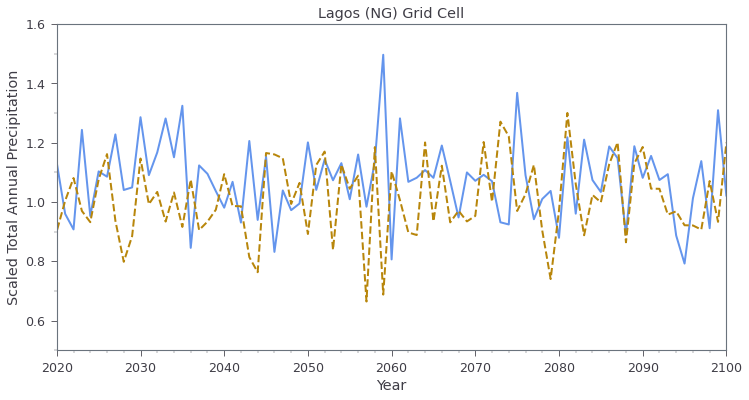

In [9]:
# Slice the data spatially using a single lat/lon point
pt_2 = moPrcp_xr['pr'].sel(lat=lat[iy_2],lon=lon[ix_2])
pt1_2 = moPrcp_xr1['pr'].sel(lat=lat1[iy1_2],lon=lon1[ix1_2])
pt2_2 = moPrcp_xr2['pr'].sel(lat=lat2[iy2_2],lon=lon2[ix2_2])

# Depth of monthly total precipitation in metric units [mm]
moPrcpM_xr_2 = pt_2 * 86400 * month_length
moPrcpM_xr1_2 = pt1_2 * 86400 * month_length1
moPrcpM_xr2_2 = pt2_2 * 86400 * month_length2
#print(moPrcpM_xr)

# sum precipitation by year
anPrcp_xr_2 = moPrcpM_xr_2.groupby('time.year').sum('time')
anPrcp_xr1_2 = moPrcpM_xr1_2.groupby('time.year').sum('time')
anPrcp_xr2_2 = moPrcpM_xr2_2.groupby('time.year').sum('time')

# Average annual precipitation
anPrcp_xr_2Avg = anPrcp_xr_2.mean()
anPrcp_xr1_2Avg = anPrcp_xr1_2.mean()
anPrcp_xr2_2Avg = anPrcp_xr2_2.mean()

# Scaled prcipitation by respective means
anPrcp_xr_2Scaled = anPrcp_xr_2 / anPrcp_xr_2Avg
anPrcp_xr1_2Scaled = anPrcp_xr1_2 / anPrcp_xr_2Avg
anPrcp_xr2_2Scaled = anPrcp_xr2_2 / anPrcp_xr2_2Avg

# You can clean up your plot as you wish using standard matplotlib approaches
f, ax = plt.subplots(figsize=(12, 6))
anPrcp_xr1_2Scaled.plot.line(hue='lat',
                    #marker="o",
                    ax=ax,
                    color="cornflowerblue",
                     linestyle='-',
                    linewidth = '2',
                    #markerfacecolor="purple",
                    #markeredgecolor="purple")
                    )
anPrcp_xr2_2Scaled.plot.line(hue='lat',
                    #marker="o",
                    ax=ax,
                    color="darkgoldenrod",
                    linestyle='--',
                    linewidth = '2',
                    #markerfacecolor="lightblue",
                    #markeredgecolor="lightblue")
                    )
ax.set_xlim(2020,2100)
ax.set_ylim(0.5,1.6)
ax.set(title="Lagos (NG) Grid Cell")
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
plt.xlabel("Year")
plt.ylabel("Scaled Total Annual Precipitation")

# Uncomment the line below if you wish to export the figure as a .png file
# plt.savefig("single_point_timeseries.png")
plt.show()

/home/smchartrand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  import sys
/home/smchartrand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.argmax(da.data) instead of da.argmin() or da.argmax().
  import sys
/home/smchartrand/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Behaviour of argmin/argmax with neither dim nor axis argument will change to return a dict of indices of each dimension. To get a single, flat index, please use np.argmin(da.data) or np.arg

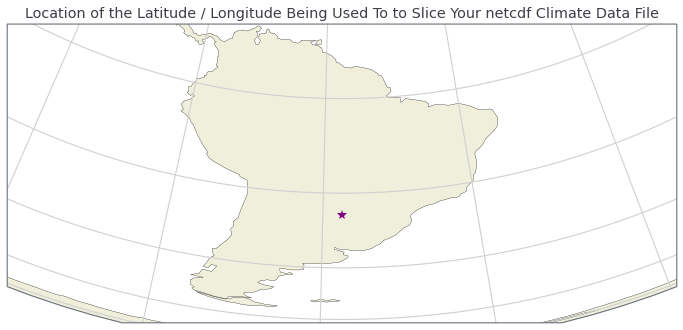

In [10]:
#25.2637° S, 57.5759° W
# specify some locations to extract time series
loni3 = 302.5; lati3 = -25.2 # Lagos

# find closest index to specified value
def near(array,value):
    idx=(abs(array-value)).argmin()
    return idx

# Find nearest point to desired location (could also interpolate, but more work)
ix_3 = near(lon, loni3)
iy_3 = near(lat, lati3)

ix1_3 = near(lon1, loni3)
iy1_3 = near(lat1, lati3)

ix2_3 = near(lon2, loni3)
iy2_3 = near(lat2, lati3)

# Create a spatial map of your selected location with cartopy
extent = [lon1[ix1_3] - 40, lon1[ix1_3] + 40, lat1[iy1_3] + 30, lat1[iy1_3] - 30]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

f, ax = plt.subplots(figsize=(12, 6),subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)})
ax.coastlines()
# Plot the selected location 
ax.plot(loni3-360, lati3,'r*', 
        transform=ccrs.PlateCarree(),
       color="purple", markersize=10)

ax.set_extent(extent)
ax.set(title="Location of the Latitude / Longitude Being Used To to Slice Your netcdf Climate Data File")

# Adds continent boundaries to the map
ax.add_feature(cfeature.LAND, edgecolor='black')

ax.gridlines()
plt.show()

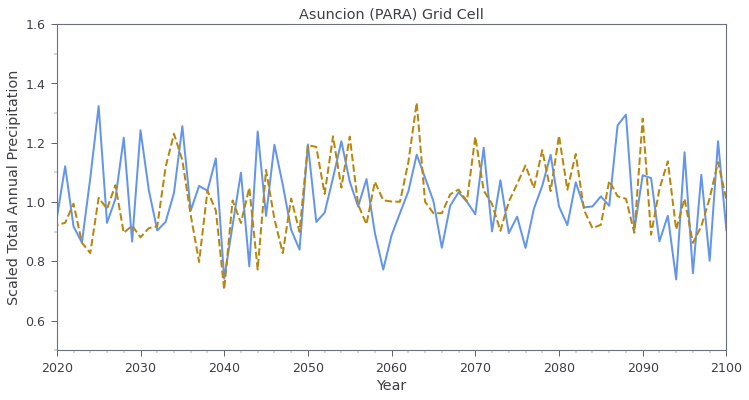

In [11]:
# Slice the data spatially using a single lat/lon point
pt_3 = moPrcp_xr['pr'].sel(lat=lat[iy_3],lon=lon[ix_3])
pt1_3 = moPrcp_xr1['pr'].sel(lat=lat1[iy1_3],lon=lon1[ix1_3])
pt2_3 = moPrcp_xr2['pr'].sel(lat=lat2[iy2_3],lon=lon2[ix2_3])

# Depth of monthly total precipitation in metric units [mm]
moPrcpM_xr_3 = pt_3 * 86400 * month_length
moPrcpM_xr1_3 = pt1_3 * 86400 * month_length1
moPrcpM_xr2_3 = pt2_3 * 86400 * month_length2
#print(moPrcpM_xr)

# sum precipitation by year
anPrcp_xr_3 = moPrcpM_xr_3.groupby('time.year').sum('time')
anPrcp_xr1_3 = moPrcpM_xr1_3.groupby('time.year').sum('time')
anPrcp_xr2_3 = moPrcpM_xr2_3.groupby('time.year').sum('time')

# Average annual precipitation
anPrcp_xr_3Avg = anPrcp_xr_3.mean()
anPrcp_xr1_3Avg = anPrcp_xr1_3.mean()
anPrcp_xr2_3Avg = anPrcp_xr2_3.mean()

# Scaled prcipitation by respective means
anPrcp_xr_3Scaled = anPrcp_xr_3 / anPrcp_xr_3Avg
anPrcp_xr1_3Scaled = anPrcp_xr1_3 / anPrcp_xr1_3Avg
anPrcp_xr2_3Scaled = anPrcp_xr2_3 / anPrcp_xr2_3Avg


# You can clean up your plot as you wish using standard matplotlib approaches
f, ax = plt.subplots(figsize=(12, 6))
anPrcp_xr1_3Scaled.plot.line(hue='lat',
                    #marker="o",
                    ax=ax,
                    color="cornflowerblue",
                     linestyle='-',
                    linewidth = '2',
                    #markerfacecolor="purple",
                    #markeredgecolor="purple")
                    )
anPrcp_xr2_3Scaled.plot.line(hue='lat',
                    #marker="o",
                    ax=ax,
                    color="darkgoldenrod",
                    linestyle='--',
                    linewidth = '2',
                    #markerfacecolor="lightblue",
                    #markeredgecolor="lightblue")
                    )
ax.set_xlim(2020,2100)
ax.set_ylim(0.5,1.6)
ax.set(title="Asuncion (PARA) Grid Cell")
ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(.1))
plt.xlabel("Year")
plt.ylabel("Scaled Total Annual Precipitation")

# Uncomment the line below if you wish to export the figure as a .png file
# plt.savefig("single_point_timeseries.png")
plt.show()

In [12]:
# 50 values for later use from 0 to 1
blues = cm.Blues(np.linspace(0,1, num=50))
grays = cm.Greys(np.linspace(0,1, num=50))

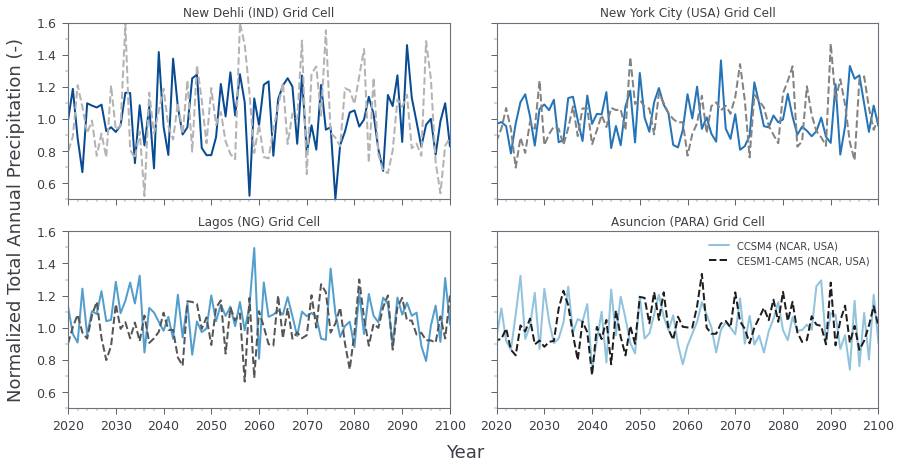

In [13]:
# Four Panel Subplot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(12, 6),sharex='all', sharey='all',constrained_layout=True)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

anPrcp_xr1Scaled.plot.line(#marker="o",
                    ax=ax1,color=blues[44],linestyle='-',linewidth = '2',
                    #markerfacecolor="purple",
                    #markeredgecolor="purple")
                    )
anPrcp_xr2Scaled.plot.line(#marker="o",
                    ax=ax1,color=grays[20],linestyle='--',linewidth = '2',
                    #markerfacecolor="lightblue",
                    #markeredgecolor="lightblue",
                          )                          
ax1.set_xlim(2020,2100)
ax1.set_ylim(0.5,1.6)
ax1.set_title("New Dehli (IND) Grid Cell",size=12)
ax1.xaxis.set_minor_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(.1))
ax1.set_xlabel("")

#

anPrcp_xr1_1Scaled.plot.line(#marker="o",
                    ax=ax2,color=blues[36],linestyle='-',linewidth = '2',
                    #markerfacecolor="purple",
                    #markeredgecolor="purple")
                    )
anPrcp_xr2_1Scaled.plot.line(#marker="o",
                    ax=ax2,color=grays[28],linestyle='--',linewidth = '2',
                    #markerfacecolor="lightblue",
                    #markeredgecolor="lightblue")
                    )
ax2.set_xlim(2020,2100)
ax2.set_ylim(0.5,1.6)
ax2.set_title("New York City (USA) Grid Cell",size=12)
ax2.xaxis.set_minor_locator(MultipleLocator(2))
ax2.yaxis.set_minor_locator(MultipleLocator(.1))
ax2.set_xlabel("")

#

anPrcp_xr1_2Scaled.plot.line(#marker="o",
                    ax=ax3,color=blues[28],linestyle='-',linewidth = '2',
                    #markerfacecolor="purple",
                    #markeredgecolor="purple")
                    )
anPrcp_xr2_2Scaled.plot.line(#marker="o",
                    ax=ax3,color=grays[36],linestyle='--',linewidth = '2',
                    #markerfacecolor="lightblue",
                    #markeredgecolor="lightblue")
                    )
ax3.set_xlim(2020,2100)
ax3.set_ylim(0.5,1.6)
ax3.set_title("Lagos (NG) Grid Cell",size=12)
ax3.xaxis.set_minor_locator(MultipleLocator(2))
ax3.yaxis.set_minor_locator(MultipleLocator(.1))
ax3.set_xlabel("")

#

anPrcp_xr1_3Scaled.plot.line(#marker="o",
                    ax=ax4,color=blues[20],linestyle='-',linewidth = '2',
                    #markerfacecolor="purple",
                    #markeredgecolor="purple")
                    )
anPrcp_xr2_3Scaled.plot.line(#marker="o",
                    ax=ax4,color=grays[44],linestyle='--',linewidth = '2',
                    #markerfacecolor="lightblue",
                    #markeredgecolor="lightblue")
                    )
ax4.set_xlim(2020,2100)
ax4.set_ylim(0.5,1.6)
ax4.set_title("Asuncion (PARA) Grid Cell",size=12)
ax4.xaxis.set_minor_locator(MultipleLocator(2))
ax4.yaxis.set_minor_locator(MultipleLocator(.1))
ax4.set_xlabel("")
ax4.legend(labels,fontsize=10)

# Set common labels
fig.text(0.5, -0.04, 'Year', ha='center', va='center',fontsize=18)
fig.text(-0.02, 0.5, 'Normalized Total Annual Precipitation (-)', ha='center', va='center', rotation='vertical',fontsize=18)

plt.savefig("GlobalPr_timeseries.png",dpi=300, bbox_inches = "tight")
